In [1]:
import gpytorch
import UncertainKernel
import UncertainMeanZero
import math
import torch
from matplotlib import pyplot as plt

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x_mean = torch.linspace(0, 1, 20)
# We'll assume the variance shrinks the closer we get to 1
train_x_stdv = torch.linspace(0.03, 0.01, 20)
inputsZipped = torch.tensor(list(zip(train_x_mean, train_x_stdv)))

# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x_mean * (2 * math.pi)) + torch.randn(train_x_mean.size()) * 0.2

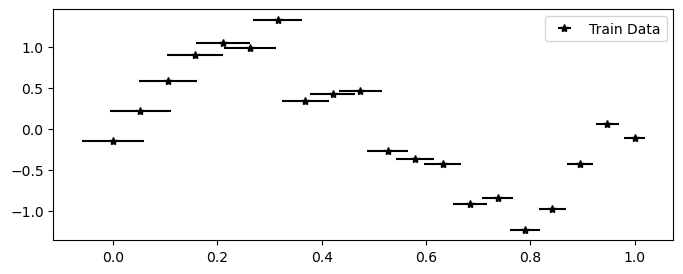

In [3]:
f, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.errorbar(train_x_mean, train_y, xerr=(train_x_stdv * 2), fmt="k*", label="Train Data")
ax.legend()

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = UncertainMeanZero.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(UncertainKernel.UncertainKernel())
        # self.covar_module = LaplacianKernel.LaplacianKernel()


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(inputsZipped, train_y, likelihood)

In [6]:
training_iter = 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(inputsZipped)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/500 - Loss: 1.084   lengthscale: 0.693   noise: 0.693
Iter 2/500 - Loss: 1.062   lengthscale: 0.644   noise: 0.644
Iter 3/500 - Loss: 1.039   lengthscale: 0.598   noise: 0.598
Iter 4/500 - Loss: 1.016   lengthscale: 0.554   noise: 0.555
Iter 5/500 - Loss: 0.992   lengthscale: 0.513   noise: 0.513
Iter 6/500 - Loss: 0.967   lengthscale: 0.474   noise: 0.475
Iter 7/500 - Loss: 0.941   lengthscale: 0.437   noise: 0.438
Iter 8/500 - Loss: 0.912   lengthscale: 0.403   noise: 0.404
Iter 9/500 - Loss: 0.880   lengthscale: 0.371   noise: 0.372
Iter 10/500 - Loss: 0.843   lengthscale: 0.340   noise: 0.342
Iter 11/500 - Loss: 0.802   lengthscale: 0.312   noise: 0.315
Iter 12/500 - Loss: 0.758   lengthscale: 0.285   noise: 0.288
Iter 13/500 - Loss: 0.715   lengthscale: 0.260   noise: 0.264
Iter 14/500 - Loss: 0.677   lengthscale: 0.237   noise: 0.241
Iter 15/500 - Loss: 0.645   lengthscale: 0.217   noise: 0.219
Iter 16/500 - Loss: 0.618   lengthscale: 0.199   noise: 0.200
Iter 17/500 - Los

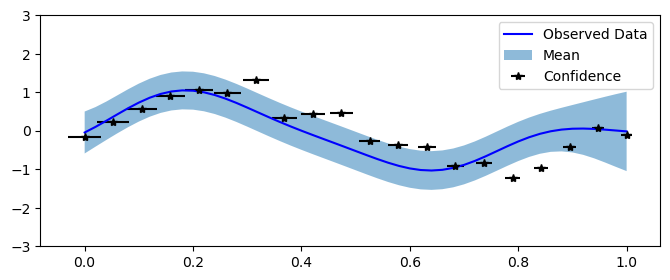

In [9]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.lazily_evaluate_kernels(False):
    test_x = torch.linspace(0, 1, 51)
    test_x_distributional = torch.stack((test_x, (0 * torch.ones_like(test_x))), dim=1)
    observed_pred = likelihood(model(test_x_distributional))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=train_x_stdv, fmt='k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [ ]:
test_y = torch.sin(test_x * (2 * math.pi))

In [ ]:
torch.mean(torch.abs(test_y - observed_pred.mean))

tensor(0.6233)